# Solve 1D and 2D Schödinger Equation on Uniform and Non-Uniform Grids

In this notebook we will explain methods for solving the time independent 
Schödinger equation (TISE) both in the case of a uniformly spaced mesh grid 
and non-uniformly spaced mesh grid.

Change base working directory. 

In [1]:
# Since we don't actually have a package yet for people to install.. 
# We need to add our folder to the PYTHONPATH in order for import to find qudipy
import os
from pathlib import Path
path = Path(os.getcwd())

# update base working directory to QuDiPy
if path.stem != 'QuDiPy':
    print(path.parents[1])

    base_dir = path.parents[1]
    os.chdir(base_dir)
else:
    base_dir = path

c:\QuDiPy


Load necessary modules.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator, interp1d
from itertools import product

from qudipy.system import DotArray
from qudipy.utils import constants
from qudipy.utils import find_nearest
import qudipy.potential as pot
import qudipy.qutils as qt

# Initialize the Material class with the Si/SiO2 material system 
mat_system = constants.select_material('Si/SiO2')

## Create dots object

If desired create a dot object for conditional use when solving the TISE. To do this, 
un-comment/comment `%%script false --no-raise-error` in the following cell, as well as,
the necessary cells that follow.

In [3]:
#%script false --no-raise-error

nav_dir = os.path.join('QuDiPy data', 'tutorials')
processed_dir = os.path.join(base_dir, nav_dir,
                            'processed','2QD_processed')
nextnano_dir = os.path.join(base_dir, nav_dir,
                                    'nextnano','2QD_dotsep_60nm')
n_dots = 2      # anticipated number of dots

eff_interp_dims = [4,3,4]
ctrl_vals = [np.linspace(0.2, 0.45, eff_interp_dims[0]),
            np.linspace(-0.1, 0.15, eff_interp_dims[1]),
            np.linspace(0.2, 0.45, eff_interp_dims[2])]

file_prefix = 'tutorial'

dots = DotArray(n_dots, ctrl_ranges=ctrl_vals)
dots.numeric(processed_dir, nextnano_dir, file_prefix)

Loading pre-calculated spin interpolators from
c:\QuDiPy\QuDiPy data\tutorials\processed\2QD_processed\tutorial_spin_data_size_[4 3 4]_from_[ 0.2 -0.1  0.2]_to_[0.45 0.15 0.45].pkl


## Create Analytic Gaussian Potentials

Instead of using a potential from a dots object, an analytic potential for a Gaussian
single or double dot may be used. Two functions are defined for this conditional use.

In [4]:
def upside_down_gaussian_2d(x, y, sigma=2.0):
    """
    Calculate the upside-down Gaussian function in 2D.

    Parameters:
    - x: Input array for the x-axis.
    - y: Input array for the y-axis.
    - sigma: Standard deviation parameter (default is 2.0).

    Returns:
    - 2D array representing the upside-down Gaussian function.
    """
    X, Y = np.meshgrid(x, y)
    exponent = -0.5 * ((X**2 + Y**2) / (sigma ** 2))
    # scale/shift gaussian to mimic dot object potential
    return (-0.15*np.exp(exponent) - 3)*1e-19

In [5]:
def upside_down_double_gaussian_2d(x, y, mu_x1=2, mu_x2=2, sigma=0.5):
    """
    Define a 2D quartic function as an upside-down Gaussian with an additional quartic term.

    Parameters:
    - x: Input array for the x-axis.
    - y: Input array for the y-axis.
    - mu_x1: Mean of left gaussian quantum dot.
    - mu_x2: Mean of right gaussian quantum dot.
    - sigma: Standard deviation parameter (default is 0.5).

    Returns:
    - 2D array representing the upside-down quartic function.
    """
    X, Y = np.meshgrid(x, y)
    exponent = -0.5 * (((X-mu_x1)**2 + Y**2) / (sigma ** 2))
    exponent2 = -0.5 * (((X+mu_x2)**2 + Y**2) / (sigma ** 2))

    # scale/shift gaussian to mimic dot object potential
    return -0.5 * (np.exp(exponent) + np.exp(exponent2) - 3)*1e-19

## Generate 1D & 2D potentials for Later Use

### Use Gaussian Potential

Un-comment/comment `%%script false --no-raise-error` in the dot object creation cell and the following two cells to 
either use a Gaussian potential or a Dots object potential.

Single "Dot" Gaussian

In [6]:
# %%script false --no-raise-error

# define non-uniform grid
plus_x_values = np.logspace(0, 2, 100)
plus_y_values = np.logspace(0, 1.75, 50)
# define uniform grid
inbetween_x_values = np.linspace(-0.99,0.99, 100)
inbetween_y_values = np.linspace(-0.99,0.99, 50)

# generate a coordinate system made of uniform and non-uniform grid spacings
x_coords = np.hstack((-1.0*plus_x_values[::-1],inbetween_x_values, plus_x_values))
y_coords = np.hstack((-1.0*plus_y_values[::-1],inbetween_y_values, plus_y_values))

# convert units to meters
x_coords = np.multiply(x_coords, 1e-9)
y_coords = np.multiply(y_coords, 1e-9)

# generate 2D potential
sigma_value = 3e-8
pot_2d = upside_down_gaussian_2d(x_coords, y_coords, sigma=sigma_value)

print(f'Shape of x-coordinates = {np.shape(x_coords)}')
print(f'Shape of y-coordinates = {np.shape(y_coords)}')

# find index closest to y = 0nm
y_idx = find_nearest(y_coords, 0)[0]

# take slice along y_idx for 1D potential along x-coordinates 
pot_1d = pot_2d[y_idx]

Shape of x-coordinates = (300,)
Shape of y-coordinates = (150,)


Double "Dot" Gaussian

In [7]:
%%script false --no-raise-error

# define non-uniform grid
plus_x_values = np.logspace(0, 2.25, 75)
plus_y_values = np.logspace(0, 1.85, 50)
# define uniform grid
inbetween_x_values = np.linspace(-0.99,0.99, 10)
inbetween_y_values = np.linspace(-0.99,0.99, 10)
# generate a coordinate system made of uniform and non-uniform grid spacings
x_coords = np.hstack((-1.0*plus_x_values[::-1],inbetween_x_values, plus_x_values))
y_coords = np.hstack((-1.0*plus_y_values[::-1],inbetween_y_values, plus_y_values))

# convert units to meters
x_coords = np.multiply(x_coords, 1e-9)
y_coords = np.multiply(y_coords, 1e-9)

# generate 2D potential
sigma_value = 3e-8
dot_sep = 100e-9
dot_sep = 150e-9
pot_2d = upside_down_double_gaussian_2d(x_coords, y_coords, mu_x1=dot_sep/2, mu_x2=dot_sep/2, sigma=sigma_value)

print(f'Shape of x-coordinates = {np.shape(x_coords)}')
print(f'Shape of y-coordinates = {np.shape(y_coords)}')

# find index closest to y = 0nm
y_idx = find_nearest(y_coords, 0)[0]

# take slice along y_idx for 1D potential along x-coordinates 
pot_1d = pot_2d[y_idx]

Couldn't find program: 'false'


### Use Dots Potential

Currently ignoring Dots potential. Comment out `%%script false --no-raise-error`
to use this potential instead.

In [8]:
%%script false --no-raise-error

# Choose voltage control values
voltage_config = [0.2,0.,0.2]
dot1, dot2 = dots.split(group='single')

# get non-uniform coordinates
x_coords = dot1.potential.x_coords
y_coords = dot1.potential.y_coords

print(f'Shape of x-coordinates = {np.shape(x_coords)}')
print(f'Shape of y-coordinates = {np.shape(y_coords)}')

# orginal 2D potential on a non-uniform grid
pot_2d = dot1.potential(voltage_config)

# find index closest to y = 0nm
y_idx = find_nearest(y_coords, 0)[0]

# take slice along y_idx for 1D potential along x-coordinates 
pot_1d = pot_2d[y_idx]

Couldn't find program: 'false'


### Plot Selected 1D/2D/3D Potential: Non-Uniform Grid

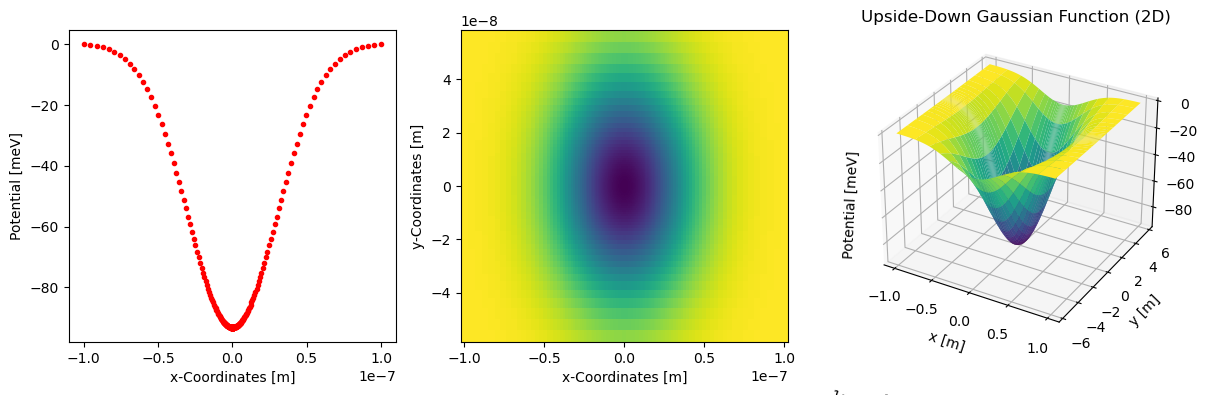

In [9]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(131)
ax1.plot(x_coords, (pot_1d- np.max(pot_1d))*(1e3/constants.e), '.r')

ax2 = fig.add_subplot(132)
ax2.pcolormesh(x_coords, y_coords, (pot_2d- np.max(pot_2d))*(1e3/constants.e))

ax1.set_ylabel('Potential [meV]')
ax1.set_xlabel('x-Coordinates [m]')
ax2.set_ylabel('y-Coordinates [m]')
ax2.set_xlabel('x-Coordinates [m]')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(*np.meshgrid(x_coords, y_coords), (pot_2d- np.max(pot_2d))*(1e3/constants.e), cmap='viridis')

ax3.set_title('Upside-Down Gaussian Function (2D)')
ax3.set_xlabel('x [m]')
ax3.set_ylabel('y [m]')
ax3.set_zlabel('Potential [meV]', labelpad=-150)
# ax3.dist = 14
plt.tight_layout()

## Create Potentials Over Uniform Grid

Create interpolation objects and new uniform grid coordinates.

In [10]:
# generate interpolation objects
interpolation_1d = interp1d(x_coords, pot_1d)
interpolation_2d = RegularGridInterpolator((y_coords, x_coords), pot_2d, method='slinear')

# define new uniform grid
uniform_x = np.linspace(np.min(x_coords), np.max(x_coords), len(x_coords))
uniform_y = np.linspace(np.min(y_coords), np.max(y_coords), len(y_coords))

# create new 1D potential
uniform_pot_1d = interpolation_1d(uniform_x)

# create new 1D potential
unifrom_grid = np.meshgrid(uniform_y, uniform_x)
grid = list(product(uniform_y, uniform_x))
uniform_pot_2d = interpolation_2d(grid).reshape(len(y_coords),len(x_coords))


### Plot Selected 1D/2D/3D Potential: Uniform Grid

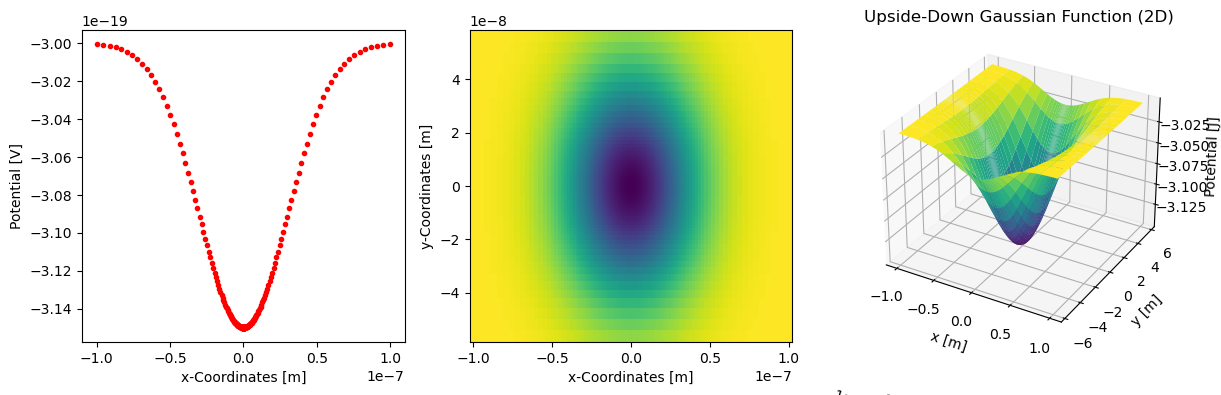

In [11]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(131)
ax1.plot(x_coords, pot_1d, '.r')

ax2 = fig.add_subplot(132)
ax2.pcolormesh(x_coords, y_coords, pot_2d)

ax1.set_ylabel('Potential [V]')
ax1.set_xlabel('x-Coordinates [m]')
ax2.set_ylabel('y-Coordinates [m]')
ax2.set_xlabel('x-Coordinates [m]')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(*np.meshgrid(x_coords, y_coords), pot_2d, cmap='viridis')

ax3.set_title('Upside-Down Gaussian Function (2D)')
ax3.set_xlabel('x [m]')
ax3.set_ylabel('y [m]')
ax3.set_zlabel('Potential [J]')

plt.tight_layout()

## Solve TISE for Both Grids

### 1D Non-uniform grid solution

In [12]:
gparams = pot.GridParameters(x_coords, potential=pot_1d)
# pass gparams to the solve_schrodinger_eq qutils method to obtain the eigenvalues and eigenvectors
e_ens_1d, e_vecs_1d = qt.solvers.solve_schrodinger_eq(mat_system, gparams, n_sols=15)

Plot 1D eigenvectors found on non-uniform grid.

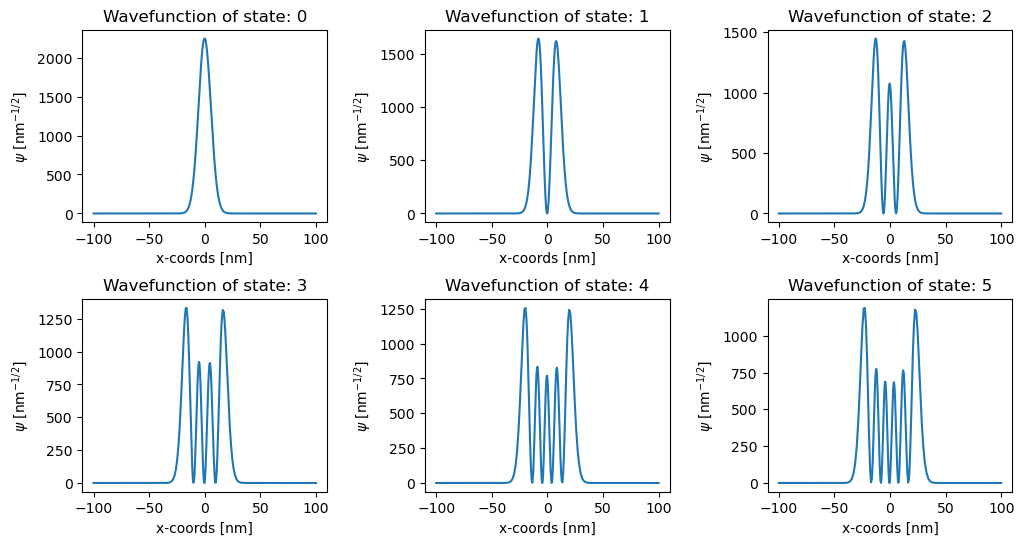

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
for idx, ax in enumerate(axes.flat):
    ax.plot(gparams.x/1E-9, np.abs(e_vecs_1d[:,idx])**2 / np.sqrt(1e9))
    ax.set_title("Wavefunction of state: "+str(idx))
    ax.set(xlabel='x-coords [nm]')
    ax.set(ylabel='$\\psi\ [\\mathrm{nm}^{-{1}/{2}}]$')

plt.show()

### 1D Uniform grid solutions

In [14]:
uniform_gparams = pot.GridParameters(uniform_x, potential=uniform_pot_1d)
# pass gparams to the solve_schrodinger_eq qutils method to obtain the eigenvalues and eigenvectors
uniform_e_ens_1d, uniform_e_vecs_1d = qt.solvers.solve_schrodinger_eq(mat_system, uniform_gparams, n_sols=15)

# NOTE: If needed, the old schrodinger solver for uniform grids can be called
uniform_e_ens_old_1d, uniform_e_vecs_old_1d = qt.solvers.solve_schrodinger_eq_old(mat_system, uniform_gparams, n_sols=15)

Plot 1D eigenvectors found on uniform grid.

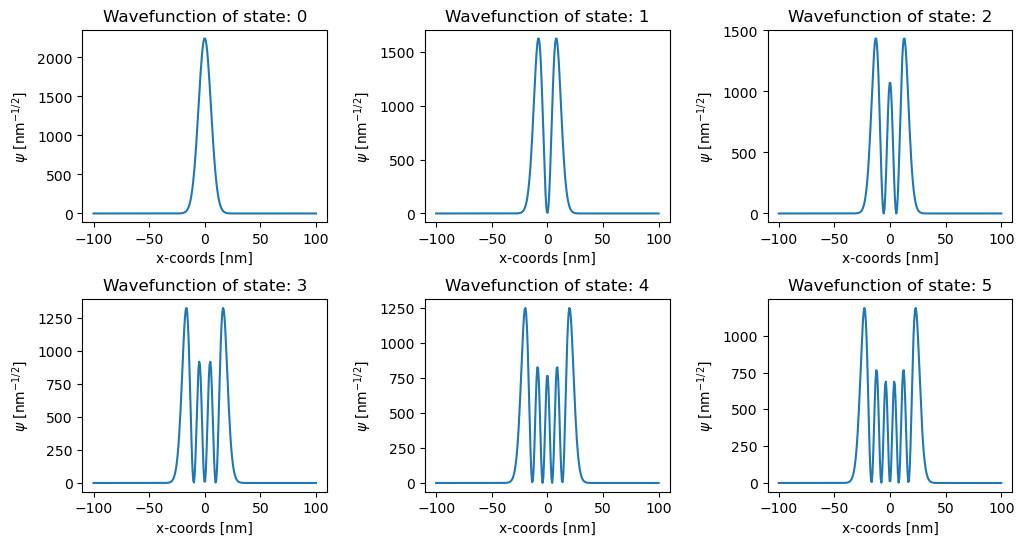

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

fig.subplots_adjust(hspace=0.4, wspace=0.4)

for idx, ax in enumerate(axes.flat):
    ax.plot(uniform_gparams.x/1E-9,  np.abs(uniform_e_vecs_1d[:,idx])**2 / np.sqrt(1e9))
    ax.set_title("Wavefunction of state: "+str(idx))
    ax.set(xlabel='x-coords [nm]')
    ax.set(ylabel='$\\psi\ [\\mathrm{nm}^{-{1}/{2}}]$')

plt.show()

Print energy eigenvalues for non-uniform grid in eV.

In [16]:
print(e_ens_1d*(1/constants.e))
print(uniform_e_ens_1d*(1/constants.e))

print(f'Difference in Energy [meV]')
print(abs(e_ens_1d - uniform_e_ens_1d)*(1e3/constants.e))

print(f'Difference in Energy for new vs old uniform mesh grid schrodinger solver [meV]')
print(abs(uniform_e_ens_1d - uniform_e_ens_old_1d)*(1e3/constants.e))

[-1.96289753+0.j -1.95662808+0.j -1.95053026+0.j -1.94460985+0.j
 -1.93887   +0.j -1.93331592+0.j -1.92795123+0.j -1.92278097+0.j
 -1.91780918+0.j -1.91304105+0.j -1.90848114+0.j -1.90413514+0.j
 -1.90000845+0.j -1.89610772+0.j -1.89243981+0.j]
[-1.96289677+0.j -1.95662681+0.j -1.95053229+0.j -1.94461541+0.j
 -1.93887867+0.j -1.93332494+0.j -1.92795743+0.j -1.92277949+0.j
 -1.91779489+0.j -1.91300818+0.j -1.90842417+0.j -1.90404839+0.j
 -1.89988738+0.j -1.89594824+0.j -1.89223981+0.j]
Difference in Energy [meV]
[0.0007649  0.0012705  0.0020293  0.00556395 0.00866464 0.0090207
 0.00620687 0.00148432 0.01428537 0.032868   0.0569701  0.08675651
 0.12107473 0.15948147 0.2000041 ]
Difference in Energy for new vs old uniform mesh grid schrodinger solver [meV]
[0.00000000e+00 0.00000000e+00 3.00517731e-13 0.00000000e+00
 0.00000000e+00 3.00517731e-13 0.00000000e+00 6.01035461e-13
 3.00517731e-13 3.00517731e-13 3.00517731e-13 6.01035461e-13
 3.00517731e-13 3.00517731e-13 1.20207092e-11]


Plot energy vs state from the 1D Schrodinger solver.

15
15


c:\Users\esocc\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


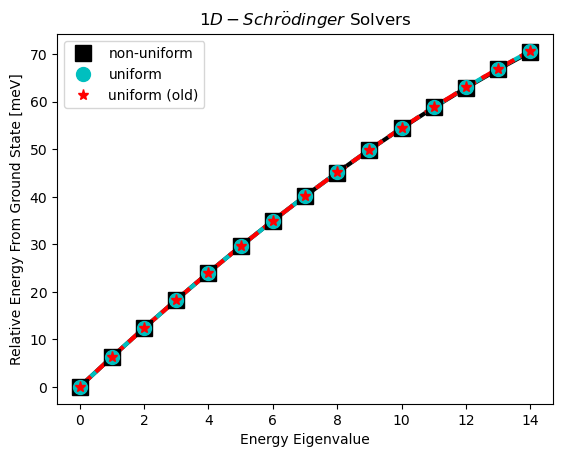

In [17]:
states = range(np.shape(e_vecs_1d)[1])

print(len(states))
print(len(e_ens_1d))
line_sz = 3
plt.figure()
# plt.scatter(states, (e_ens - e_ens[0])*(1e3/constants.e) , marker='o', color='r', label='non-uniform')
# plt.scatter(states, (uniform_e_ens - uniform_e_ens[0])*(1e3/constants.e) , marker='o', color='b', label='uniform')
# plt.scatter(states, (e_ens)*(1e3/constants.e) , marker='.', color='r', label='non-uniform')
# plt.scatter(states, (uniform_e_ens)*(1e3/constants.e) , marker='.', color='b', label='uniform')
plt.plot(states, (e_ens_1d - e_ens_1d[0])*(1e3/constants.e) , 'sk', label='non-uniform', markersize=12, linewidth=line_sz)
plt.plot(states, (uniform_e_ens_1d - uniform_e_ens_1d[0])*(1e3/constants.e) , 'oc', label='uniform', markersize=10, linewidth=line_sz)
plt.plot(states, (uniform_e_ens_old_1d - uniform_e_ens_old_1d[0])*(1e3/constants.e) , '*r', label='uniform (old)', markersize=8, linewidth=line_sz)


plt.plot(states, (e_ens_1d - e_ens_1d[0])*(1e3/constants.e) , '-k', markersize=12, linewidth=line_sz, zorder=-1)
plt.plot(states, (uniform_e_ens_1d - uniform_e_ens_1d[0])*(1e3/constants.e) , '-.c', markersize=10, linewidth=line_sz, zorder=-1)
plt.plot(states, (uniform_e_ens_old_1d - uniform_e_ens_old_1d[0])*(1e3/constants.e) , '--r', markersize=8, linewidth=line_sz, zorder=-1)

plt.xlabel('Energy Eigenvalue')
plt.ylabel('Relative Energy From Ground State [meV]')
plt.title(r'$1D-Schr {\"o} dinger$ Solvers')
plt.legend()

### 2D Non-uniform grid solution

In [18]:
gparams = pot.GridParameters(x_coords, y_coords, potential=pot_2d)
# pass gparams to the solve_schrodinger_eq qutils method to obtain the eigenvalues and eigenvectors
e_ens_2d, e_vecs_2d = qt.solvers.solve_schrodinger_eq(mat_system, gparams, n_sols=15)

Plot 2D eigenvectors found on non-uniform grid.

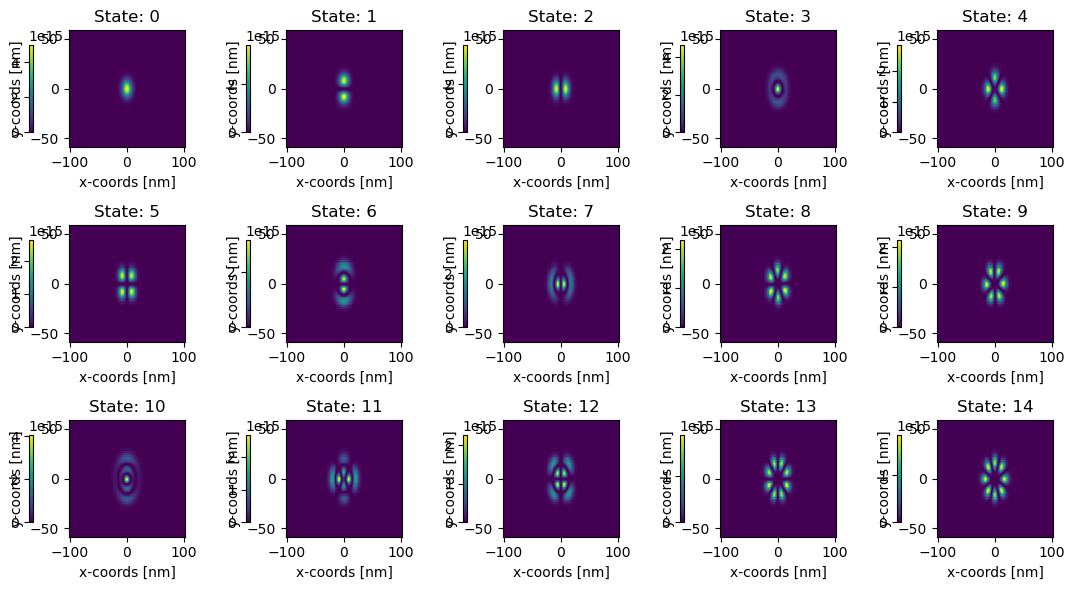

In [19]:
fig, axes = plt.subplots(3, 5, figsize=(11, 6))

fig.subplots_adjust(hspace=0.45, wspace=0.3)

for idx, ax in enumerate(axes.flat):
    #ax.imshow(gparams.potential, cmap='viridis', 
    im = ax.pcolormesh(gparams.x/1E-9, 
                        gparams.y/1E-9,
                        np.real(np.multiply(e_vecs_2d[:,:,idx],e_vecs_2d[:,:,idx].conj())),
                        cmap='viridis')
                                
    ax.set_title("State: "+str(idx))
    ax.set(xlabel='x-coords [nm]',ylabel='y-coords [nm]')
    clb_pot = fig.colorbar(im, ax=ax, location='left', shrink=0.75, pad=0.2)

plt.tight_layout()
plt.show()

## Plot energies verse state

### 2D Uniform grid solution

In [20]:
uniform_gparams = pot.GridParameters(uniform_x, uniform_y, potential=uniform_pot_2d)
# pass sparams, gparams to the solve_schrodinger_eq qutils method to obtain the eigenvalues and eigenvectors
uniform_e_ens_2d, uniform_e_vecs_2d = qt.solvers.solve_schrodinger_eq(mat_system, uniform_gparams, n_sols=15)

# NOTE: If needed, the old schrodinger solver for uniform grids can be called
uniform_e_ens_old_2d, uniform_e_vecs_old_2d = qt.solvers.solve_schrodinger_eq_old(mat_system, uniform_gparams, n_sols=15)


Print energy eigenvalues for uniform grid in eV and difference between energy 
eigenvalues from non-uniform grid.

In [21]:
print(e_ens_2d*(1/constants.e))
print(uniform_e_ens_2d*(1/constants.e))

print(f'Difference in Energy [meV]')
print(abs(e_ens_2d - uniform_e_ens_2d)*(1e3/constants.e))

print(f'Difference in Energy for new vs old uniform mesh grid schrodinger solver [meV]')
print(abs(uniform_e_ens_2d - uniform_e_ens_old_2d)*(1e3/constants.e))

[-1.95975125+0.j -1.9535491 +0.j -1.95353857+0.j -1.94756763+0.j
 -1.94745358+0.j -1.94745151+0.j -1.94172985+0.j -1.9416981 +0.j
 -1.94148244+0.j -1.94148195+0.j -1.93611083+0.j -1.93598748+0.j
 -1.93597542+0.j -1.9356362 +0.j -1.93563457+0.j]
[-1.95974564+0.j -1.95353248+0.j -1.95353222+0.j -1.94755258+0.j
 -1.9474404 +0.j -1.94743417+0.j -1.94169537+0.j -1.94169232+0.j
 -1.94146239+0.j -1.94146232+0.j -1.93607428+0.j -1.93596643+0.j
 -1.93594955+0.j -1.9356101 +0.j -1.93560988+0.j]
Difference in Energy [meV]
[0.00561069 0.01662398 0.00635955 0.01504538 0.01317509 0.01734505
 0.03447539 0.00577908 0.02005465 0.01963271 0.03655248 0.0210502
 0.02586782 0.02609556 0.02468526]
Difference in Energy for new vs old uniform mesh grid schrodinger solver [meV]
[3.00517731e-13 0.00000000e+00 3.00517731e-13 0.00000000e+00
 3.00517731e-13 3.00517731e-13 1.02176028e-11 0.00000000e+00
 6.01035461e-13 3.00517731e-12 1.58973879e-10 1.78207014e-10
 1.44248511e-11 1.38238156e-11 4.32745532e-11]


Plot 2D eigenvectors found on uniform grid.

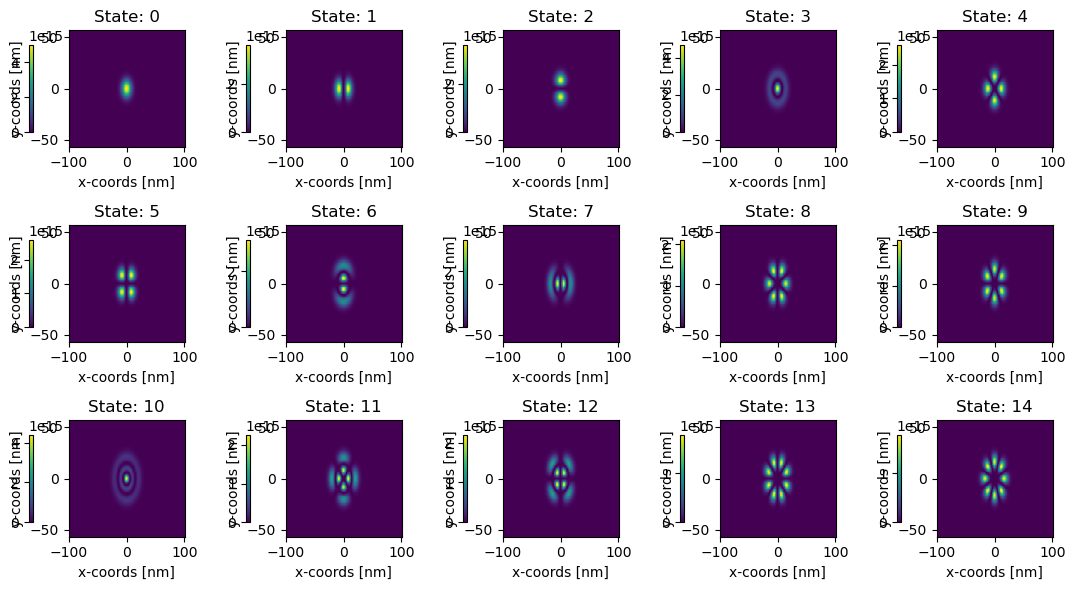

In [22]:
fig, axes = plt.subplots(3, 5, figsize=(11, 6))

fig.subplots_adjust(hspace=0.45, wspace=0.3)

for idx, ax in enumerate(axes.flat):
    #ax.imshow(gparams.potential, cmap='viridis', 
    im = ax.pcolormesh(uniform_gparams.x/1E-9, 
                        uniform_gparams.y/1E-9,
                        np.real(np.multiply(uniform_e_vecs_2d[:,:,idx],uniform_e_vecs_2d[:,:,idx].conj())),
                        cmap='viridis')
                                
    ax.set_title("State: "+str(idx))
    ax.set(xlabel='x-coords [nm]',ylabel='y-coords [nm]')
    clb_pot = fig.colorbar(im, ax=ax, location='left', shrink=0.75, pad=0.2)

plt.tight_layout()
plt.show()

Plot energy vs state from the 2D Schrodinger solver.

15
15


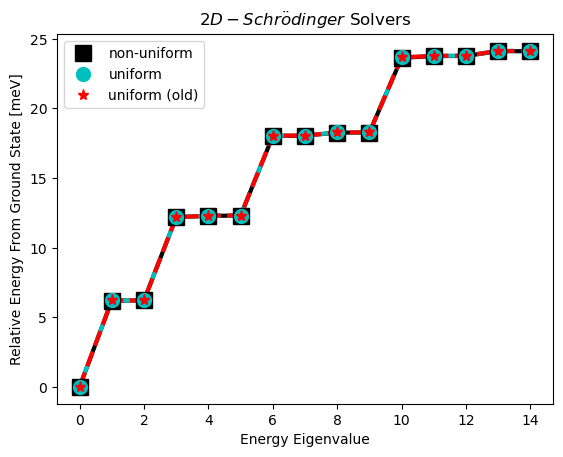

In [23]:
states = range(np.shape(e_vecs_2d)[2])

print(len(states))
print(len(e_ens_2d))
line_sz = 3
plt.figure()
# plt.scatter(states, (e_ens - e_ens[0])*(1e3/constants.e) , marker='o', color='r', label='non-uniform')
# plt.scatter(states, (uniform_e_ens - uniform_e_ens[0])*(1e3/constants.e) , marker='o', color='b', label='uniform')
# plt.scatter(states, (e_ens)*(1e3/constants.e) , marker='.', color='r', label='non-uniform')
# plt.scatter(states, (uniform_e_ens)*(1e3/constants.e) , marker='.', color='b', label='uniform')
plt.plot(states, (e_ens_2d - e_ens_2d[0])*(1e3/constants.e) , 'sk', label='non-uniform', markersize=12, linewidth=line_sz)
plt.plot(states, (uniform_e_ens_2d - uniform_e_ens_2d[0])*(1e3/constants.e) , 'oc', label='uniform', markersize=10, linewidth=line_sz)
plt.plot(states, (uniform_e_ens_old_2d - uniform_e_ens_old_2d[0])*(1e3/constants.e) , '*r', label='uniform (old)', markersize=8, linewidth=line_sz)


plt.plot(states, (e_ens_2d - e_ens_2d[0])*(1e3/constants.e) , '-k', markersize=12, linewidth=line_sz, zorder=-1)
plt.plot(states, (uniform_e_ens_2d - uniform_e_ens_2d[0])*(1e3/constants.e) , '-.c', markersize=10, linewidth=line_sz, zorder=-1)
plt.plot(states, (uniform_e_ens_old_2d - uniform_e_ens_old_2d[0])*(1e3/constants.e) , '--r', markersize=8, linewidth=line_sz, zorder=-1)

plt.xlabel('Energy Eigenvalue')
plt.ylabel('Relative Energy From Ground State [meV]')
plt.title(r'$2D-Schr {\"o} dinger$ Solvers')
plt.legend()